Controversial Picks Calculator (by Bobby Mills and Arseny Khakhalin)

For now this script doesn't perform a full analysis. It needs to be run on the set for human player, then it should be manually made run for a bot, and then there's an R script named `controversial_picks_part2.R` that finalizes the comparison.

In [1]:
import pandas as pd
import numpy as np

import csv
import json

import re

import itertools

import matplotlib.pyplot as plt
import mpld3

In [2]:
from draftsim_utils_ab import *

In [3]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)

Change the set abbrevation below to work with a different set

In [5]:
# Alternatives: XLN, DOM, M19, GRN, RNA
setName = 'RNA'

In [7]:
thisSet = mtgJSON[setName]['cards']

thisSet = {getName(card) : card for card in thisSet} # a dict with names as indices for cards, for all cards in set

In [9]:
dataFileNames = {
    'XLN': '../../2018-02-23 Two days data XLN.csv',
    'DOM': '../../2018-04-16 Dominiaria initial data-2.csv',
    'M19': '../../2018-08-23 m19 drafts round 2.csv',
    'GRN': '../../2018-10-05 GRN Draft Data 1.csv',
    'RNA': '../../2019-01-22 RNA merged.csv'
}

draftData = pd.read_csv(dataFileNames[setName], 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])

draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3095772,RNA,"Angel_of_Grace,Final_Payment,Concordia_Pegasus...","Biomancer's_Familiar,Incubation_Incongruity,Wr...","Biomancer's_Familiar,Sharktocrab,Applied_Bioma...","Zegana,_Utopian_Speaker,Sharktocrab,Rubble_Sli...","Tithe_Taker,Forbidding_Spirit,Civic_Stalwart,S...","Skewer_the_Critics,Get_the_Point,Light_Up_the_...","Spirit_of_the_Spires,Verity_Circle,Orzhov_Guil...","Sphinx_of_New_Prahv,Tenth_District_Veteran,Imp..."
3095773,RNA,"Zegana,_Utopian_Speaker,Sharktocrab,Sharktocra...","Precognitive_Perception,Azorius_Guildgate_2,Ar...","Windstorm_Drake,Arrester's_Admonition,Cry_of_t...","Mortify,Code_of_Constraint,Sky_Tether,Gateway_...","Growth-Chamber_Guardian,Flames_of_the_Raze-Boa...","Enraged_Ceratok,Skewer_the_Critics,Grotesque_D...","Incubation_Druid,Clan_Guildmage,Gruul_Beastmas...","Kaya's_Wrath,Arrester's_Admonition,Arrester's_..."
3095774,RNA,"Bedevil,Rubblebelt_Recluse,Cindervines,Noxious...","Repudiate_Replicate,Rampaging_Rendhorn,Depose_...","Repudiate_Replicate,Frilled_Mystic,Gift_of_Str...","Wilderness_Reclamation,Scorchmark,Collision_Co...","Grotesque_Demise,Carnival_Carnage,Orzhov_Guild...","Warrant_Warden,Sphinx_of_New_Prahv,Lawmage's_B...","Skarrgan_Hellkite,Scorchmark,Hackrobat,Rubble_...","Skarrgan_Hellkite,Wilderness_Reclamation,Incub..."
3095775,RNA,"Mortify,Haazda_Officer,Archway_Angel,Concordia...","Domri,_Chaos_Bringer,Biogenic_Upgrade,Regenesi...","Trollbred_Guardian,Arrester's_Admonition,Arres...","Ethereal_Absolution,Summary_Judgment,Final_Pay...","Incubation_Incongruity,Arrester's_Admonition,S...","Growth-Chamber_Guardian,Repudiate_Replicate,Sw...","Bedevil,Blade_Juggler,Rakdos_Firewheeler,Cry_o...","Skewer_the_Critics,Skewer_the_Critics,Zhur-Taa..."
3095776,RNA,"Get_the_Point,Gruul_Guildgate_2,Simic_Guildgat...","Enraged_Ceratok,End-Raze_Forerunners,Titanic_B...","Grotesque_Demise,Final_Payment,Orzhov_Racketee...","Mesmerizing_Benthid,Growth-Chamber_Guardian,Co...","Biomancer's_Familiar,Open_the_Gates,Summary_Ju...","Biomancer's_Familiar,Growth_Spiral,Humongulus,...","Nikya_of_the_Old_Ways,Arrester's_Admonition,Su...","Incubation_Druid,Gruul_Beastmaster,Applied_Bio..."


In [10]:
#print(thisSet.keys())
dict((k.lower(), v) for k, v in thisSet.items()) # Lowercase the keys
cardlist = list(thisSet.keys())
#print(cardlist)

Main loop, but it's actually quite fast (~10 s).

In [37]:
cardpicks = {card : [] for card in cardlist} # Pick order
cardpickOn = {card : [] for card in cardlist} # Pick order on color

draftCount = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
for draft in draftData[player]:
    draft = fixName(draft)
    draft = draft.lower()
    draft = draft.split(',')
    draftCount += 1
    #colorCount = {i : 0 for i in range(0,6)}
    colorCount = [0,0,0,0,0,0,0]
    for i in range(14):
        try:
            cardpicks[draft[i]].append(i+1)
            bestColorSoFar = np.argmax(colorCount)
            if bestColorSoFar==0 or getCardColor(thisSet[draft[i]]) == bestColorSoFar:
                cardpickOn[draft[i]].append(i+1)
            colorCount[getCardColor(thisSet[draft[i]])] += 1            
        except KeyError as e:
            print(draft)
            print(count)
            raise
    #if any('karn_scion_of_urza' in x for x in draft):
    #    print(cardpicks['karn_scion_of_urza'][-1])
    #    #print(draft)
    
print("Analyzed ",draftCount," records.")

Analyzed  88388  records.


In [38]:
for card in cardpicks:
    if cardpicks[card] == []:
        cardpicks[card].append(15)
        
for card in cardpickOn:
    if cardpickOn[card] == []:
        cardpickOn[card].append(15)

Text(0,0.5,'Frequency')

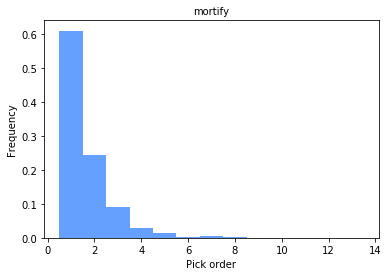

In [39]:
#cardpicks['karn_scion_of_urza']
#cardpicks['karn_scion_of_urza']
#cardpicks['chance_for_glory']

goodCardName = 'mortify' 
# Controversial in GRN: ionize, chance_for_glory. Well known: leapfrog, silent_dart

# Histogram of cardpicks
fig, ax = plt.subplots()
n, bins, patches = plt.hist(cardpicks[goodCardName], 13, range=(0.5,13.5), density=True, facecolor=(0.2,0.5,1), alpha=0.75)
ax.set_title(goodCardName, size=10)
plt.xlabel('Pick order')
plt.ylabel('Frequency') 

In [40]:
cardpicksdf = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity' :[thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks]
    }, list(cardpicks.keys()))
#cardpicksdf.head()

In [41]:
cardpickOndf = pd.DataFrame({
        'avg' : [np.mean(cardpickOn[card]) for card in cardpickOn],
        'var' : [np.var(cardpickOn[card]) for card in cardpickOn],
        'count' : [len(cardpickOn[card]) for card in cardpickOn],
        'color' : [getCardColor(thisSet[card]) for card in cardpickOn],
        'rarity' :[thisSet[card]['rarity'] for card in cardpickOn],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpickOn]
    }, list(cardpickOn.keys()))

In [42]:
if player=='human':
    cardpicksdf.to_csv('../../data/controversial_cards_'+setName+'.csv', index_label="name")
    #cardpickOndf.to_csv('../../data/controversial_cards_data_onColor.csv', index_label="name")
else:
    cardpicksdf.to_csv('../../data/controversial_cards_'+setName+'_bot.csv', index_label="name")
    #cardpickOndf.to_csv('../../data/controversial_cards_data_onColor_bot.csv', index_label="name")

In [43]:
cardpicksdf.sort_values(by=['var'], ascending=False).head(10)
#cardpicksdf.iloc[0]['rarity'] == 'Common'

,avg,var,count,color,rarity,legendary
kaya_orzhov_usurper,7.556142,18.431290,2841,1,mythic,1
emergency_powers,9.225240,17.575998,1878,1,mythic,0
cindervines,9.100991,17.569219,3129,1,rare,0
smothering_tithe,7.875270,17.315905,2317,2,rare,0
mirror_march,7.863747,16.895304,2055,5,rare,0
high_alert,7.087882,16.653136,5166,1,uncommon,0
absorb,7.259969,16.539184,3812,1,rare,0
lavinia_azorius_renegade,9.277665,15.910682,2946,1,rare,1
godless_shrine,7.583935,15.191521,4569,1,rare,0
awaken_the_erstwhile,9.748383,15.175369,1546,4,rare,0


In [23]:
def getHeights(picks):
    heights = [0 for x in range(16)]
    
    for num in picks:
        heights[num] +=1
        
    return heights

In [24]:
colorkey = ['0', 'M', 'W', 'U', 'B', 'G', 'R']
colorid = ['#9F9F9F', 'DC03FD', '#F3C750', '#0E68AB', '#150B00', '#00733E', '#D3202A']
mplcolors = ['gray', 'mediumvioletred', 'orange', 'dodgerblue', 'black', 'g', 'red']


In [25]:
mplrarity = ['crimson','orange','gray', 'black', 'w']
rarity= ['Mythic Rare', 'Rare', 'Uncommon', 'Common', 'Basic Land']

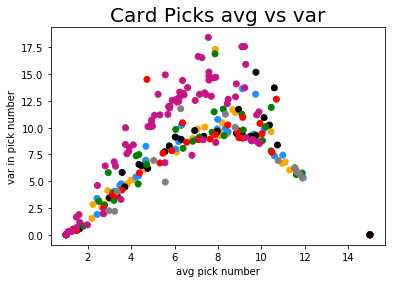

In [26]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplcolors[x] for x in cardpicksdf['color']]
                    )

ax.set_title("Card Picks avg vs var", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 

labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvar.png')

#mpld3.display()

ValueError: 'mythic' is not in list

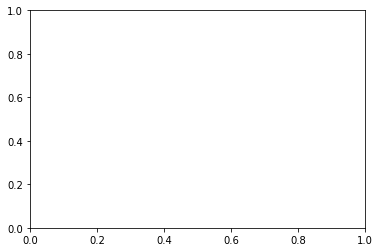

In [28]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']]
                    )

ax.set_title("Card Picks avg vs var by rarity", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvarRarityDom.png')

#mpld3.display()

ValueError: 'mythic' is not in list

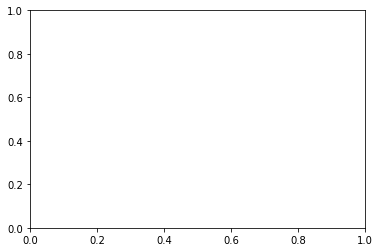

In [29]:
fig, ax = plt.subplots()

#The top scatter is for legendary cards. The bottom is non legendary.
#You can comment one out for more clarity

scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 1]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 1]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 's'
                    )
scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 0]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 0]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 'o'
                    )

ax.set_title("Card Picks avg vs var by rarity", size=10)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

plt.savefig('avgvsvarRarityDomNormal.png')

mpld3.display()